<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/02_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runtime switched to GPU
GPU device found: /device:GPU:0
Default GPU Device: /device:GPU:0


In [3]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

# Cleaning the Data

In [4]:
# Remove Na and Empty Columns

df.drop(['Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 'Customer Password', 'Customer Country', 'Customer Id', 'Customer Fname', 'Customer Lname', 'Customer Street', 'Order Country', 'Product Card Id', 'Product Category Id', 'Product Image', 'Customer State', 'shipping date (DateOrders)', 'order date (DateOrders)'], axis = 1, inplace = True) 
df.dropna(inplace = True) #remove 1 missing value

## Encoding

### Create the Category Column

In [5]:
# define dictionaries to map status values to categories
regular_dict = {'COMPLETE': 'Regular', 'PENDING': 'Regular', 'PENDING_PAYMENT': 'Regular', 'PROCESSING': 'Regular'}
suspected_dict = {'CLOSED': 'Suspected', 'CANCELED': 'Suspected', 'ON_HOLD': 'Suspected', 'PAYMENT_REVIEW': 'Suspected'}
fraud_dict = {'SUSPECTED_FRAUD': 'Fraud'}

# create a function to map status values to categories
def map_category(status):
    if status in regular_dict:
        return regular_dict[status]
    elif status in suspected_dict:
        return suspected_dict[status]
    elif status in fraud_dict:
        return fraud_dict[status]
    else:
        return 'Unknown'

# apply the function to the 'status' column to create a new 'category' column
df['Category'] = df['Order Status'].apply(map_category)

### Label Encoding

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(['Days for shipping (real)', 'Product Name'], axis = 1)
y = df['Days for shipping (real)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [13]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Type
X['Type'] = pd.get_dummies(X['Type'])

# Category Name
X['Category Name'] = pd.get_dummies(X['Category Name'])

# Department Name
X['Department Name'] = pd.get_dummies(X['Department Name'])

# Market
X['Market'] = pd.get_dummies(X['Market'])

,CASH,DEBIT,PAYMENT,TRANSFER
0,0,1,0,0
1,0,0,0,1
2,1,0,0,0
3,0,1,0,0
4,0,0,1,0
...,...,...,...,...
180514,1,0,0,0
180515,0,1,0,0
180516,0,0,0,1
180517,0,0,1,0


In [102]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

enc = OneHotEncoder()

# Type
type_enc_array_train = enc.fit_transform(X_train['Type'].values.reshape(-1, 1)).toarray()
type_enc_array_test = enc.transform(X_test['Type'].values.reshape(-1, 1)).toarray()

type_enc_train = pd.DataFrame(type_enc_array_train, columns=enc.get_feature_names_out(['Type']))
type_enc_test = pd.DataFrame(type_enc_array_test, columns=enc.get_feature_names_out(['Type']))

X_train = pd.concat([X_train, type_enc_train], axis=1)
X_test = pd.concat([X_test, type_enc_test], axis=1)

X_train.drop(['Type'], axis=1, inplace=True)
X_test.drop(['Type'], axis=1, inplace=True)

# Category Name
category_enc_array_train = enc.fit_transform(X_train['Category Name'].values.reshape(-1, 1)).toarray()
category_enc_array_test = enc.transform(X_test['Category Name'].values.reshape(-1, 1)).toarray()

category_enc_train = pd.DataFrame(category_enc_array_train, columns=enc.get_feature_names_out(['Category Name']))
category_enc_test = pd.DataFrame(category_enc_array_test, columns=enc.get_feature_names_out(['Category Name']))

X_train = pd.concat([X_train, category_enc_train], axis=1)
X_test = pd.concat([X_test, category_enc_test], axis=1)

X_train.drop(['Category Name'], axis=1, inplace=True)
X_test.drop(['Category Name'], axis=1, inplace=True)

# Department Name
department_enc_array_train = enc.fit_transform(X_train['Department Name'].values.reshape(-1, 1)).toarray()
department_enc_array_test = enc.transform(X_test['Department Name'].values.reshape(-1, 1)).toarray()

department_enc_train = pd.DataFrame(department_enc_array_train, columns=enc.get_feature_names_out(['Department Name']))
department_enc_test = pd.DataFrame(department_enc_array_test, columns=enc.get_feature_names_out(['Department Name']))

X_train = pd.concat([X_train, department_enc_train], axis=1)
X_test = pd.concat([X_test, department_enc_test], axis=1)

X_train.drop(['Department Name'], axis=1, inplace=True)
X_test.drop(['Department Name'], axis=1, inplace=True)

# Market
market_enc_array_train = enc.fit_transform(X_train['Market'].values.reshape(-1, 1)).toarray()
market_enc_array_test = enc.transform(X_test['Market'].values.reshape(-1, 1)).toarray()

market_enc_train = pd.DataFrame(market_enc_array_train, columns=enc.get_feature_names_out(['Market']))
market_enc_test = pd.DataFrame(market_enc_array_test, columns=enc.get_feature_names_out(['Market']))

X_train = pd.concat([X_train, market_enc_train], axis=1)
X_test = pd.concat([X_test, market_enc_test], axis=1)

X_train.drop(['Market'], axis=1, inplace=True)
X_test.drop(['Market'], axis=1, inplace=True)

# Order Status
order_status_enc_array_train = enc.fit_transform(X_train['Order Status'].values.reshape(-1, 1)).toarray()
order_status_enc_array_test = enc.transform(X_test['Order Status'].values.reshape(-1, 1)).toarray()

order_status_enc_train = pd.DataFrame(order_status_enc_array_train, columns=enc.get_feature_names_out(['Order Status']))
order_status_enc_test = pd.DataFrame(order_status_enc_array_test, columns=enc.get_feature_names_out(['Order Status']))

X_train = pd.concat([X_train, order_status_enc_train], axis=1)
X_test = pd.concat([X_test, order_status_enc_test], axis=1)

X_train.drop(['Order Status'], axis=1, inplace=True)
X_test.drop(['Order Status'], axis=1, inplace=True)

# Customer Segment
customer_segment_enc_array_train = enc.fit_transform(X_train['Customer Segment'].values.reshape(-1, 1)).toarray()
customer_segment_enc_array_test = enc.transform(X_test['Customer Segment'].values.reshape(-1, 1)).toarray()

customer_segment_enc_train = pd.DataFrame(customer_segment_enc_array_train, columns=enc.get_feature_names_out(['Customer Segment']))
customer_segment_enc_test = pd.DataFrame(customer_segment_enc_array_test, columns=enc.get_feature_names_out(['Customer Segment']))

X_train = pd.concat([X_train, customer_segment_enc_train], axis=1)
X_test = pd.concat([X_test, customer_segment_enc_test], axis=1)

X_train.drop(['Customer Segment'], axis=1, inplace=True)
X_test.drop(['Customer Segment'], axis=1, inplace=True)

# Category
category_enc_array_train = enc.fit_transform(X_train['Category'].values.reshape(-1, 1)).toarray()
category_enc_array_test = enc.transform(X_test['Category'].values.reshape(-1, 1)).toarray()

category_enc_train = pd.DataFrame(category_enc_array_train, columns=enc.get_feature_names_out(['Category']))
category_enc_test = pd.DataFrame(category_enc_array_test, columns=enc.get_feature_names_out(['Category']))

X_train = pd.concat([X_train, category_enc_train], axis=1)
X_test = pd.concat([X_test, category_enc_test], axis=1)

X_train.drop(['Category'], axis=1, inplace=True)
X_test.drop(['Category'], axis=1, inplace=True)

In [101]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()

# Type
X_train['Type'] = enc.fit_transform(X_train['Type'])
X_test['Type'] = enc.transform(X_test['Type'])

# Category Name
X_train['Category Name'] = enc.fit_transform(X_train['Category Name'])
X_test['Category Name'] = enc.transform(X_test['Category Name'])

# Department Name
X_train['Department Name'] = enc.fit_transform(X_train['Department Name'])
X_test['Department Name'] = enc.transform(X_test['Department Name'])

# Market
X_train['Market'] = enc.fit_transform(X_train['Market'])
X_test['Market'] = enc.transform(X_test['Market'])

# Order Status
X_train['Order Status'] = enc.fit_transform(X_train['Order Status'])
X_test['Order Status'] = enc.transform(X_test['Order Status'])

# Customer Segment
X_train['Customer Segment'] = enc.fit_transform(X_train['Customer Segment'])
X_test['Customer Segment'] = enc.transform(X_test['Customer Segment'])

# Category
X_train['Category'] = enc.fit_transform(X_train['Category'])
X_test['Category'] = enc.transform(X_test['Category'])


AttributeError: ignored

In [ ]:
X_train['Order Region'].value_counts()

In [44]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Delivery Status
X_train['Delivery Status'] = le.fit_transform(X_train['Delivery Status'])
X_test['Delivery Status'] = le.transform(X_test['Delivery Status'])

# Shipping Mode
X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])


In [ ]:
import pandas as pd
!pip install category_encoders
from category_encoders import LeaveOneOutEncoder

# initialize the encoder
enc = LeaveOneOutEncoder(cols=['Customer City', 'Order City', 'Order State', 'Category Name', 'Order Region'])

# fit and transform the entire dataset
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

# Prediction

## Encode the remaining columns after the split

## Choosing the Model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize linear regression model
model = LinearRegression()

model.fit(X_train, y_train)

print(mean_squared_error(y_test, model.predict(X_test)), '\n')
print(model.summary(), '\n')

In [56]:
from sklearn.ensemble import RandomForestRegressor
import pickle

# do some grid search for this

# Initialize the model with 100 trees
model = RandomForestRegressor(n_estimators=100, max_depth=None)

# Fit the model
model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/models_lr/rf.pkl', 'wb') as file:
    pickle.dump(model, file)

mean_squared_error(y_test, model.predict(X_test))
# Mean squared error: 0.34778

0.381235868601817

In [20]:
from xgboost import XGBRegressor

model = XGBRegressor()

model.fit(X_train, y_train)

mean_squared_error(y_test, model.predict(X_test))

0.5389407490256272

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

# Define the neural network architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model with mean squared error loss function and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam', learning_rate=0.01)

# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Compute the mean squared error on the test data
mse = mean_squared_error(y_test, y_pred)

print('Mean Squared Error: {:.2f}'.format(mse))


In [76]:
X_train.shape

(144412, 36)

In [82]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define the neural network architecture
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))) 
model.add(Dense(1, activation='linear'))

# Compile the model with mean squared error loss function and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Evaluate the model on the test data
loss, mse = model.evaluate(X_test, y_test, verbose=0)
print('Mean Squared Error on test set: {:.2f}'.format(mse))

# Plot the training and validation loss over epochs
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/100
2257/2257 - 11s - loss: 122834.6328 - mean_squared_error: 122834.3750 - val_loss: 144.8471 - val_mean_squared_error: 144.6273 - 11s/epoch - 5ms/step
Epoch 2/100
2257/2257 - 8s - loss: 1441.4360 - mean_squared_error: 1441.2174 - val_loss: 333.4575 - val_mean_squared_error: 333.2379 - 8s/epoch - 4ms/step
Epoch 3/100
2257/2257 - 7s - loss: 1048.4716 - mean_squared_error: 1048.2538 - val_loss: 69.7693 - val_mean_squared_error: 69.5518 - 7s/epoch - 3ms/step
Epoch 4/100
2257/2257 - 8s - loss: 519.0576 - mean_squared_error: 518.8416 - val_loss: 111.5185 - val_mean_squared_error: 111.3051 - 8s/epoch - 4ms/step
Epoch 5/100
2257/2257 - 7s - loss: 1062.8969 - mean_squared_error: 1062.6812 - val_loss: 65.0990 - val_mean_squared_error: 64.8836 - 7s/epoch - 3ms/step
Epoch 6/100
2257/2257 - 8s - loss: 55.0284 - mean_squared_error: 54.8153 - val_loss: 44.1765 - val_mean_squared_error: 43.9656 - 8s/epoch - 3ms/step
Epoch 7/100
2257/2257 - 8s - loss: 29.5809 - mean_squared_error: 29.3716 - v

KeyboardInterrupt: ignored

In [81]:
# gradiant boosting
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.8)

model.fit(X_train, y_train)

mean_squared_error(y_test, model.predict(X_test))

KeyboardInterrupt: ignored

In [80]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Fit the model using QuantReg
quant_model = sm.QuantReg(y_train, X_train)

# Set the tau value to 0.5, which corresponds to median regression
quant_result = quant_model.fit(q=0.7, max_iter=2000)

# Print the summary of the model
print(quant_result.summary())

# Make predictions on new data
new_data = X_test
predictions = quant_result.predict(new_data)

print(mean_squared_error(y_test, predictions))

                            QuantReg Regression Results                             
Dep. Variable:     Days for shipping (real)   Pseudo R-squared:               0.6414
Model:                             QuantReg   Bandwidth:                     0.06143
Method:                       Least Squares   Sparsity:                       0.2596
Date:                      Mon, 17 Apr 2023   No. Observations:               144412
Time:                              16:58:22   Df Residuals:                   144379
                                              Df Model:                           33
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Type                              0.0189      0.001     30.394      0.000       0.018       0.020
Days for shipment (scheduled)     0.4872      0.001    868.292      0.000       0.486       0.488
Benefit per o

/usr/local/lib/python3.9/dist-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


## Performance of the Model

### Over 20 Splits

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, recall_score
import os
import pickle
import pandas as pd
import numpy as np
#!pip install category_encoders
import category_encoders as ce

within_threshold_mean = []

threshold = 0.5

results_lr = pd.DataFrame(columns=['Model', 'MSE Mean', 'MSE Std', 'Within Threshold Mean', 'Within Threshold Std'])

mse = []

# Test the model

with open('/content/drive/MyDrive/University/Deloitte/models_lr/rf.pkl', 'rb') as f:
    model = pickle.load(f)

# See if the model is good
residuals = y_test - y_pred

for i in range(1, 21):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

  le = LabelEncoder()

  # Type
  X_train['Type'] = le.fit_transform(X_train['Type']) 
  X_test['Type'] = le.transform(X_test['Type'])

  # Delivery Status
  X_train['Delivery Status'] = le.fit_transform(X_train['Delivery Status'])
  X_test['Delivery Status'] = le.transform(X_test['Delivery Status'])

  # Category Name
  X_train['Category Name'] = le.fit_transform(X_train['Category Name'])
  X_test['Category Name'] = le.transform(X_test['Category Name'])

  # Department Name
  X_train['Department Name'] = le.fit_transform(X_train['Department Name'])
  X_test['Department Name'] = le.transform(X_test['Department Name'])

  # Market
  X_train['Market'] = le.fit_transform(X_train['Market'])
  X_test['Market'] = le.transform(X_test['Market'])

  # Order Status
  X_train['Order Status'] = le.fit_transform(X_train['Order Status'])
  X_test['Order Status'] = le.transform(X_test['Order Status'])

  # Shipping Mode
  X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
  X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

  # Customer Segment
  X_train['Customer Segment'] = le.fit_transform(X_train['Customer Segment'])
  X_test['Customer Segment'] = le.transform(X_test['Customer Segment'])

  # Category
  X_train['Category'] = le.fit_transform(X_train['Category'])
  X_test['Category'] = le.transform(X_test['Category'])

  # Product Name
  X_train['Product Name'] = le.fit_transform(X_train['Product Name'])
  X_test['Product Name'] = le.transform(X_test['Product Name'])

  # Order Region
  X_train['Order Region'] = le.fit_transform(X_train['Order Region'])
  X_test['Order Region'] = le.transform(X_test['Order Region'])

  enc = LeaveOneOutEncoder(cols=['Customer City', 'Order City', 'Order State'])

  # fit and transform the entire dataset
  X_train = enc.fit_transform(X_train, y_train)
  X_test = enc.transform(X_test)

  y_pred = model.predict(X_test)
    
  mse.append(mean_squared_error(y_test, y_pred))

  # Calculate the percentage of predictions within the threshold value

  within_threshold_mean.append(sum(abs(y_pred - y_test) <= threshold) / len(y_pred))

print(f'MSE Mean: {np.mean(mse)}')
print(f'MSE Std: {np.std(mse)}')
print(f'Within Threshold Mean: {np.mean(within_threshold_mean)}')
print(f'Within Threshold Std: {np.std(within_threshold_mean)}')

## Visualization

In [68]:
from sklearn.metrics import mean_squared_error

with open('/content/drive/MyDrive/University/Deloitte/models_lr/rf.pkl', 'rb') as f:
      model = pickle.load(f)

y_pred = model.predict(X_test)
residuals = y_test - y_pred

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: " , mse, "\n")

Mean squared error:  0.381235868601817 



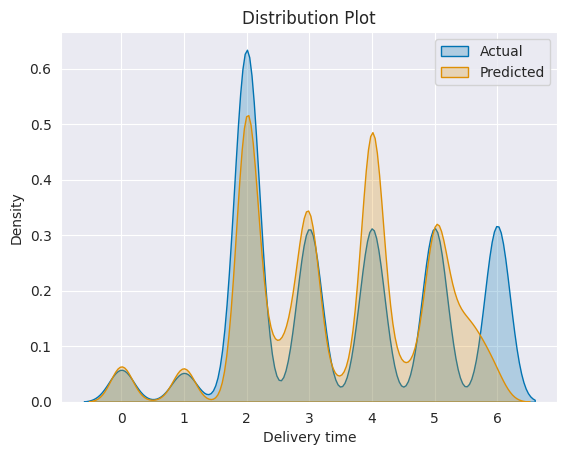

In [69]:
# Distribution plot

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('colorblind')

# Set style for the plot
sns.set_style('darkgrid')

# Create a distribution plot
sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(y_pred, label='Predicted', fill=True)
plt.xlabel('Delivery time')
plt.ylabel('Density')
plt.title('Distribution Plot')
plt.legend()
plt.show()

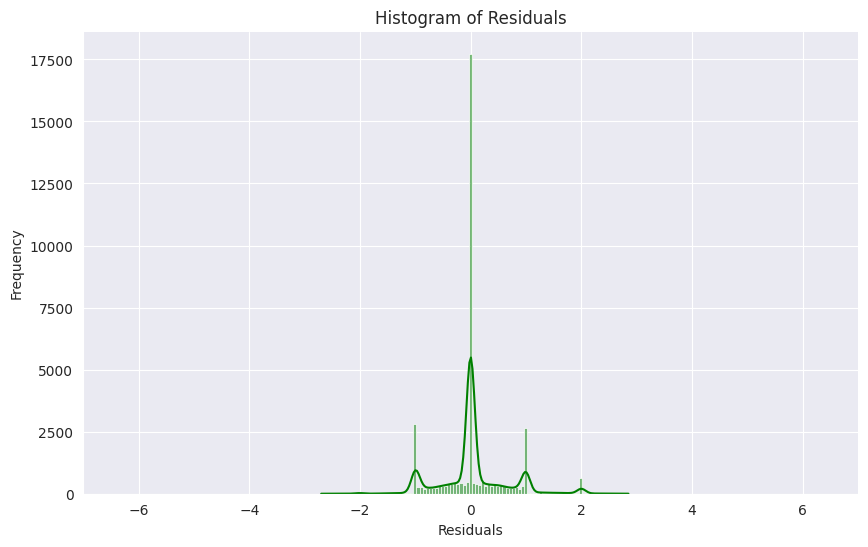

In [75]:
# Plot a histogram of the residuals

import seaborn as sns
import matplotlib.pyplot as plt

# Set style for the plot
sns.set_style('darkgrid')

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram with specified number of bins and color
sns.histplot(residuals, bins=100, color='green', kde=True, ax=ax)

# Set labels and title
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Residuals')
ax.set_xlim((-7, 7))

# Remove top and right spines
sns.despine()

# Show the plot
plt.show()

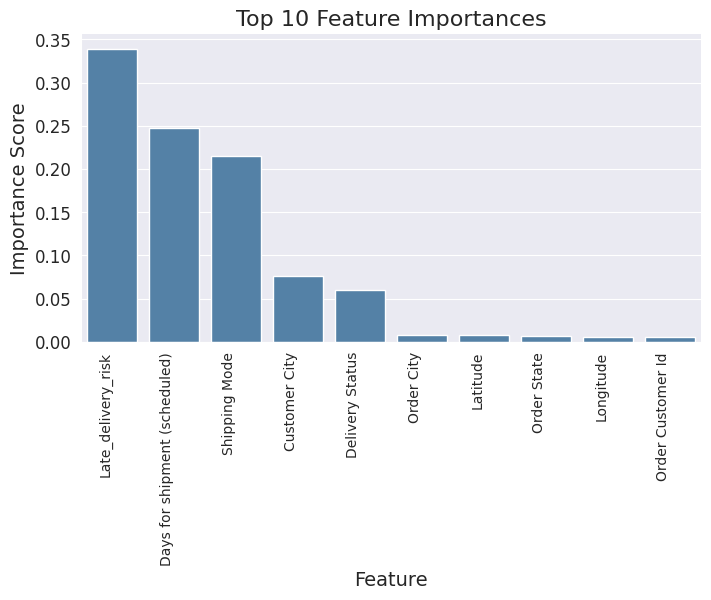

In [71]:
# Top 10 Feature Importances

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# get the feature importances
importances = model.feature_importances_

# sort the features by importance
sorted_idx = importances.argsort()[::-1]

# set style for the plot
sns.set_style('darkgrid')

# select the top 10 features
top_features = X.columns[sorted_idx][:10]
top_importances = importances[sorted_idx][:10]

# create a figure and axis objects
fig, ax = plt.subplots(figsize=(8, 4))

# create a bar chart of the top 10 features
sns.barplot(x=top_features, y=top_importances, ax=ax, color='steelblue')

# set x-axis label and rotate labels for readability
ax.set_xlabel('Feature', fontsize=14)
ax.set_xticklabels(top_features, rotation=90, ha='right', fontsize=10)

# set y-axis label and tick labels
ax.set_ylabel('Importance Score', fontsize=14)
ax.tick_params(axis='y', labelsize=12)

# set title
ax.set_title('Top 10 Feature Importances', fontsize=16)

# remove top and right spines
sns.despine()

# show the plot
plt.show()

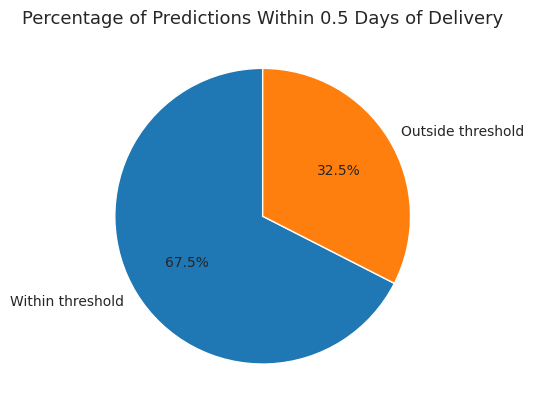

In [72]:
import matplotlib.pyplot as plt

# Set the threshold value
threshold = 0.5

# Get the predicted values
y_pred = model.predict(X_test)

# Calculate the percentage of predictions within the threshold value
within_threshold = (np.abs(y_pred - y_test) < threshold).mean()

# Calculate the percentage of predictions outside the threshold value
outside_threshold = 1 - within_threshold

# Create a pie chart
fig, ax = plt.subplots()
labels = ['Within threshold', 'Outside threshold']
sizes = [within_threshold, outside_threshold]
colors = ['#1f77b4', '#ff7f0e']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Percentage of Predictions Within 0.5 Days of Delivery', fontsize=13)

# Show the plot
plt.show()

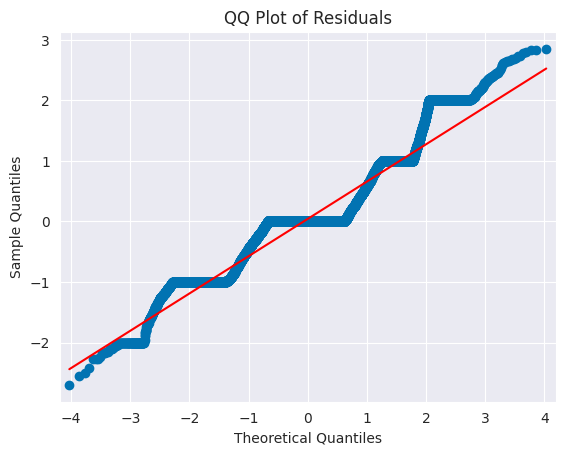

In [73]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# Get the residuals
residuals = y_test - y_pred

# Create a QQ plot
qqplot(residuals, line='s')

# Add title and axis labels
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show the plot
plt.show()